In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [55]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [56]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (12, 7)

In [57]:
train_df = pd.read_csv('data.csv')
test_df = pd.read_csv('test.csv')

test_indices = test_df['index'].copy()

In [58]:
train_df.head(10)

,index,kitchen_area,bath_area,other_area,gas,hot_water,central_heating,extra_area,extra_area_count,year,ceil_height,floor_max,floor,total_area,bath_count,extra_area_type_name,district_name,rooms_count,price
0,0,17,34,42.876495,Yes,No,Yes,3,1,2011,3.16,12,4,94.876495,2,balcony,Moskovskij,2,28285348
1,1,17,12,25.487543,Yes,Yes,Yes,11,1,1908,4.68,2,2,58.154210,1,balcony,Nevskij,2,12923063
2,2,22,35,39.041948,No,No,Yes,9,1,1953,3.12,3,2,99.041948,2,balcony,Kirovskij,3,20463247
3,3,11,26,11.646696,No,Yes,Yes,5,0,2004,2.50,15,1,50.313363,2,loggia,Krasnoselskij,0,10517141
4,4,8,14,14.406673,No,No,Yes,18,1,1970,2.50,7,2,42.406673,1,balcony,Krasnoselskij,0,8455506
5,5,10,15,34.519627,Yes,Yes,Yes,6,0,2000,3.28,10,4,61.519627,1,loggia,Kirovskij,1,11828754
6,6,16,8,22.986172,Yes,Yes,Yes,5,2,1925,3.64,2,2,48.652839,1,balcony,Krasnoselskij,2,10139447
7,7,22,30,11.402726,No,Yes,Yes,13,2,2005,2.50,12,2,67.736059,2,loggia,Krasnoselskij,1,14247682
8,8,8,36,35.612828,No,Yes,Yes,8,1,1946,2.50,3,1,82.279494,2,balcony,Vyborgskij,3,15526024
9,9,15,13,18.894486,Yes,No,Yes,3,2,1995,4.77,11,10,47.894486,1,loggia,Moskovskij,1,14248159


In [59]:
train_df.shape

(100000, 19)

In [60]:
train_df.district_name.unique()

array(['Moskovskij', 'Nevskij', 'Kirovskij', 'Krasnoselskij',
       'Vyborgskij', 'Centralnyj', 'Petrogradskij'], dtype=object)

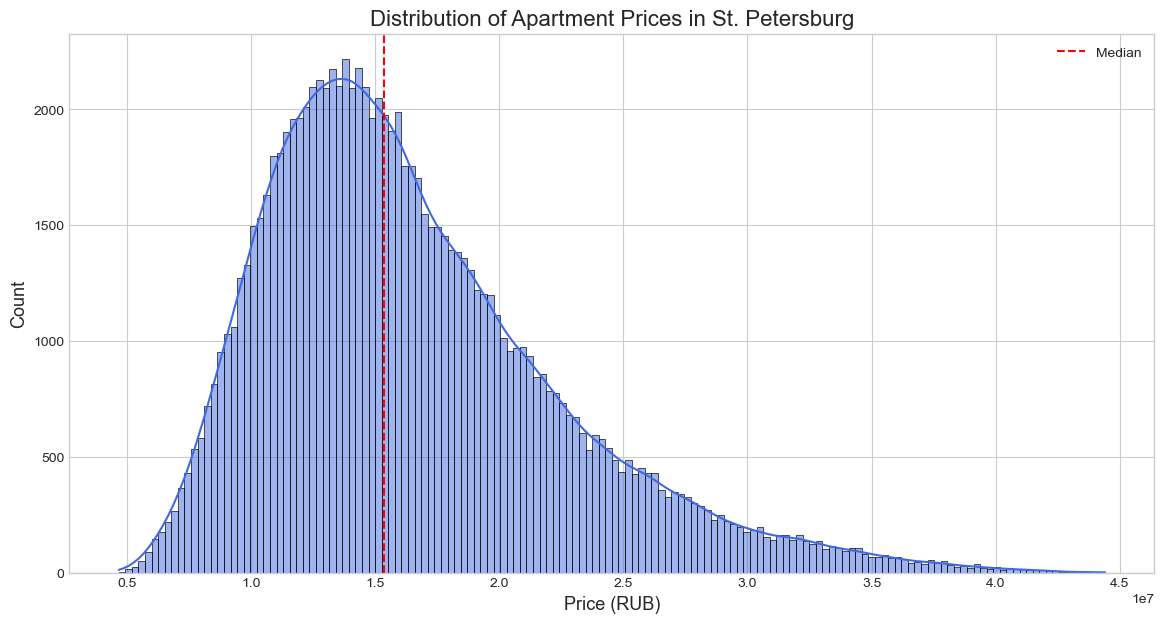

In [61]:
plt.figure(figsize=(14,7))
sns.histplot(train_df['price'], bins=150, kde=True, color='royalblue')
plt.title("Distribution of Apartment Prices in St. Petersburg", fontsize=16)
plt.xlabel("Price (RUB)", fontsize=13)
plt.ylabel("Count", fontsize=13)
plt.axvline(train_df['price'].median(), color='red', linestyle='--', label='Median')
plt.legend()
plt.show()

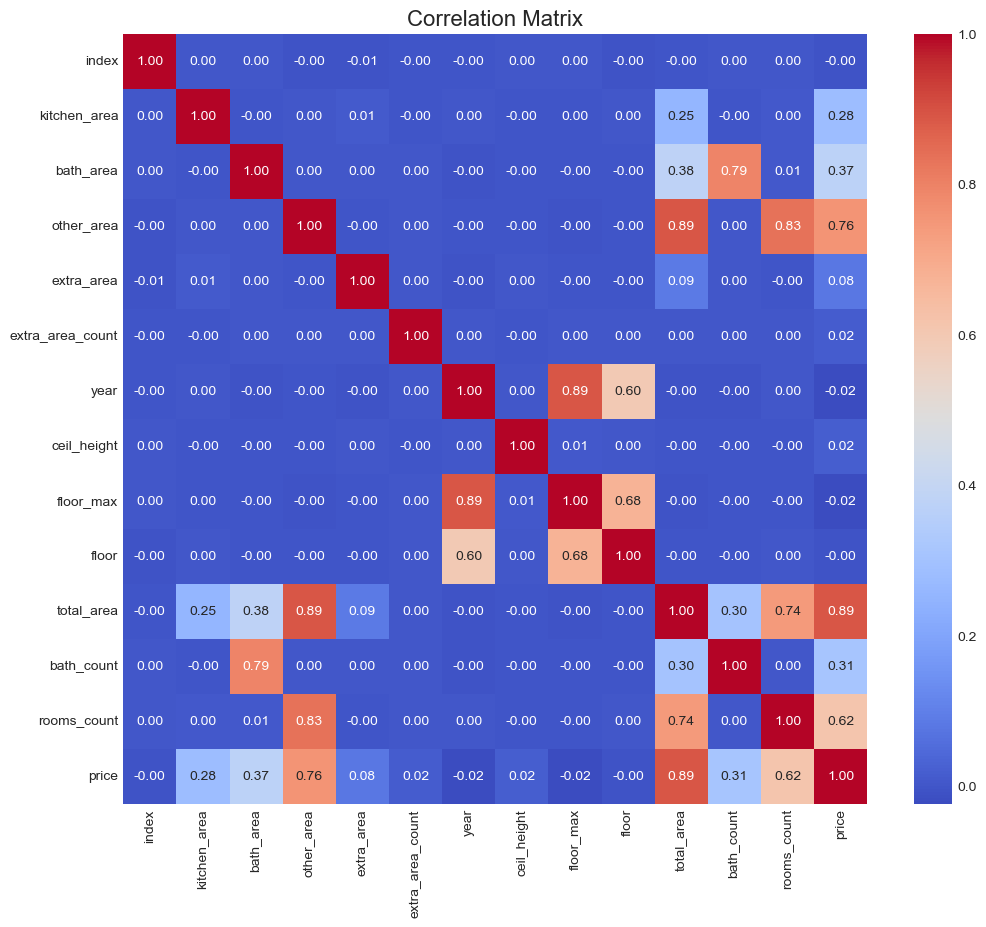

In [62]:
plt.figure(figsize=(12,10))
corr = train_df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix", fontsize=16)
plt.show()

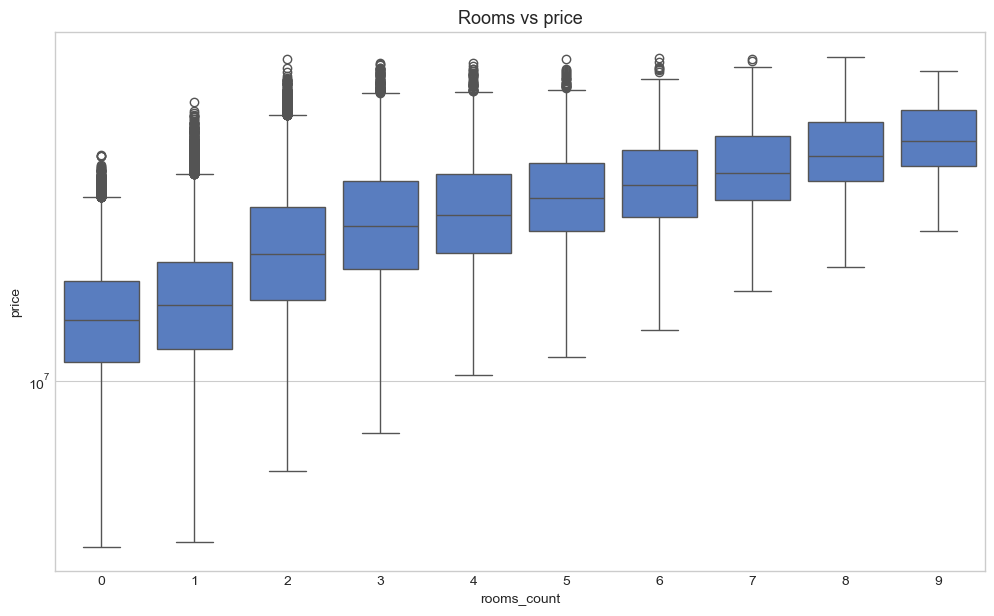

In [63]:
sns.boxplot(x='rooms_count', y='price', data=train_df)
plt.title("Rooms vs price", fontsize=13)
plt.yscale('log')
plt.show()

In [64]:
cat_features = ['gas', 'hot_water', 'central_heating','extra_area_type_name', 'district_name']

exclude_cols = ['index', 'price']
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")
print("Categorical features:", cat_features)

X = train_df[feature_cols]
y = train_df['price']
X_test = test_df[feature_cols]

Number of features: 17
Categorical features: ['gas', 'hot_water', 'central_heating', 'extra_area_type_name', 'district_name']


In [65]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=52
)

In [66]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool   = Pool(X_val, y_val, cat_features=cat_features)
full_pool  = Pool(X, y, cat_features=cat_features)
test_pool  = Pool(X_test, cat_features=cat_features)

In [67]:
model = CatBoostRegressor(
    iterations=20000,
    learning_rate=0.03,
    depth=5,
    l2_leaf_reg=5.0,
    subsample=0.8,
    colsample_bylevel=0.8,
    random_strength=1.5,
    bagging_temperature=0.7,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=55,
    verbose=500,
    early_stopping_rounds=300,
    use_best_model=True
)

model.fit(train_pool,eval_set=val_pool,plot=False)

0:	learn: 5829854.8267331	test: 5764818.5354818	best: 5764818.5354818 (0)	total: 90.5ms	remaining: 30m 10s
500:	learn: 275222.0267595	test: 228419.2769086	best: 228419.2769086 (500)	total: 43s	remaining: 27m 52s
1000:	learn: 214998.4263158	test: 185999.2078140	best: 185999.2078140 (1000)	total: 1m 22s	remaining: 26m 12s
1500:	learn: 194534.0103435	test: 173526.3131497	best: 173526.3131497 (1500)	total: 2m 5s	remaining: 25m 51s
2000:	learn: 181882.6018081	test: 167503.8066231	best: 167503.8066231 (2000)	total: 2m 51s	remaining: 25m 38s
2500:	learn: 175030.3276025	test: 163895.0963404	best: 163895.0963404 (2500)	total: 3m 42s	remaining: 25m 57s
3000:	learn: 170118.7419816	test: 161455.5969869	best: 161455.5969869 (3000)	total: 4m 28s	remaining: 25m 20s
3500:	learn: 166443.3302200	test: 159618.8915048	best: 159618.8915048 (3500)	total: 5m 5s	remaining: 24m
4000:	learn: 163570.2464603	test: 158162.2301253	best: 158162.2301253 (4000)	total: 5m 42s	remaining: 22m 50s
4500:	learn: 161164.9716

Generating feature importance plot...


C:\Users\Ruvin\AppData\Local\Temp\ipykernel_1124\2470977053.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


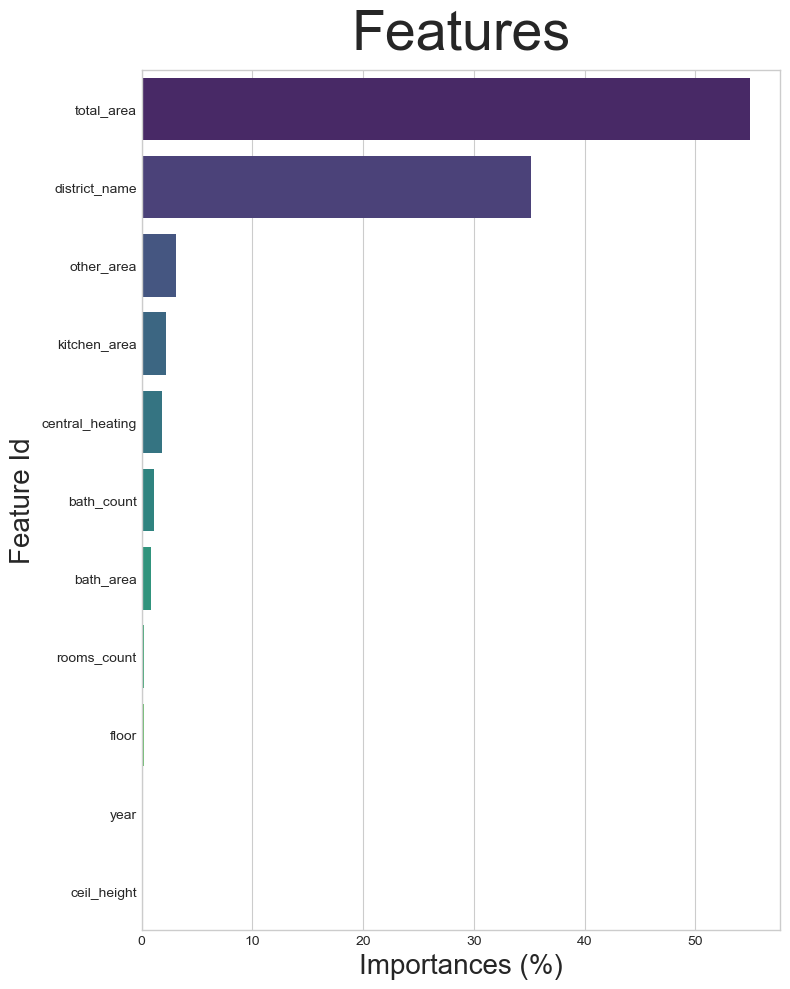

In [68]:
print("Generating feature importance plot...")

plt.figure(figsize=(8, 10))

fi = model.get_feature_importance(prettified=True)

sns.barplot(
    data=fi.head(11),
    x="Importances",
    y="Feature Id",
    palette="viridis"
)

plt.title("Features", fontsize=40, pad=15)
plt.xlabel("Importances (%)", fontsize=20)
plt.ylabel("Feature Id", fontsize=20)
plt.tight_layout()
plt.show()

In [69]:
val_pred = model.predict(X_val)

val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, val_pred)

print(f"MSE : {val_mse:,.0f}")
print(f"RMSE: {val_rmse:,.0f}")
print(f"R²  : {val_r2:.4f}")

MSE : 23,364,831,448
RMSE: 152,856
R²  : 0.9993


In [70]:
with open('flat_price_model_2026_full.pkl', 'wb') as f:
    pickle.dump(model, f)

In [71]:
print("Making predictions on test set...")
test_predictions = model.predict(test_pool)

submission = pd.DataFrame({
    'index': test_indices,
    'price': test_predictions
})

submission.to_csv('submission.csv', index=False)

print("\nSubmission file created: submission.csv")
print("First 8 predictions:")
print(submission.head(8))

Making predictions on test set...

Submission file created: submission.csv
First 8 predictions:
   index         price
0      0  1.841758e+07
1      1  1.260118e+07
2      2  2.291693e+07
3      3  1.799076e+07
4      4  1.363030e+07
5      5  9.222402e+06
6      6  1.266980e+07
7      7  1.540957e+07
